# Channel evolution analysis

In [2]:
import os
import sys
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

In [3]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.ploting import *

In [4]:
NOTEBOOK_PATH = os.getcwd()
DATA_PATH = os.path.join(NOTEBOOK_PATH, "../data_youniverse")
CATEGORY = "People & Blogs"

In [5]:
df_feather = feather.read_feather(os.path.join(DATA_PATH, 'yt_metadata_helper.feather')) # 9m : 

In [6]:
channels = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")

In [7]:
timeseries = pd.read_csv(f"{DATA_PATH}/df_timeseries_en.tsv.gz", compression="infer", sep="\t") # 20s
timeseries.head(1)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,202494.555556,0.0,650.222222,0.0,5,0,3


In [8]:
channels["join_date"] = pd.to_datetime(channels["join_date"])
timeseries["datetime"] = pd.to_datetime(timeseries["datetime"])
df_feather["upload_date"] = pd.to_datetime(df_feather["upload_date"])
df_feather["year_month"] = df_feather['upload_date'].dt.to_period('M')
df_feather["like_rate"] = df_feather["like_count"] / (df_feather["like_count"] + df_feather["dislike_count"])
channels_PB = channels[channels['category_cc'] == "People & Blogs"]
df_feather_PB = df_feather[df_feather["channel_id"].isin(channels_PB["channel"])]
timeseries_PB = timeseries[timeseries['channel'].isin(channels_PB['channel'])]
df_feather.head(1)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,year_month,like_rate
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0,2016-09,0.888889


In [9]:
channels_PB.sample(1)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
126758,People & Blogs,2010-01-08,UCHXPXLIaaWunrt6XyjDmxbg,Kano playz,12900,18,816528.0,12.337


In [11]:
def category_evolution_of_channel(channel_id, df_feather=df_feather_PB, show_evolution=False):
    '''
    Calculates the proportion of videos in the 'People & Blogs' category for a given channel.

    Parameters:
    - channel_id (str): The YouTube channel ID.
    - df_feather (DataFrame): DataFrame containing video data.

    Returns:
    - bool: True if the proportion of 'People & Blogs' videos is less than 75%, False otherwise.
    '''
    df_filtered = df_feather[df_feather["channel_id"] == channel_id]
    grouped_data = df_filtered.groupby(["year_month", "categories"]).size()
    # display(grouped_data)
    sorted_data = grouped_data.reset_index(name='count').sort_values(['year_month', 'count'], ascending=[True, False])
    if show_evolution:
        display(sorted_data)

    most_popular_cat = sorted_data.drop_duplicates(subset=["year_month"])
    # display(most_popular_cat)

    people_and_blog_proportion = (most_popular_cat["categories"] == "People & Blogs").mean()
    # print(people_and_blog_proportion)
    return people_and_blog_proportion < 0.75

In [12]:
i = 100
channels_PB_transi_mask = channels_PB[:i].progress_apply(lambda channel: category_evolution_of_channel(channel["channel"]), axis=1)
channels_PB_transi = channels_PB[:i][channels_PB_transi_mask]
print(f"There are {len(channels_PB[:i])} channels in PB category, but only {len(channels_PB_transi)} have less than 0.75 video in that category")
channels_PB_transi.sample(10)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:22<00:00,  4.43it/s]

There are 100 channels in PB category, but only 38 have less than 0.75 video in that category


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
1383,People & Blogs,2014-06-29,UCYd0us2OtW4d4-1cfpT2ktw,The Norris Nuts,3190000,208,2753.0,2.2170
513,People & Blogs,2007-10-01,UCWcrr8Q9INGNp-PTCLTzc8Q,Troye Sivan,7080000,140,891.0,2.0870
1194,People & Blogs,2006-02-07,UCHUE4ypXKp7ZkmdWbGJNgJg,AmazingPhil,4210000,271,2336.0,2.1760
1303,People & Blogs,2016-02-18,UCZDZuCogQfb1N95KuUOacjw,OnePlus India,2950000,171,2604.0,2.2005
593,People & Blogs,2016-12-27,UC8yX6-5IQGOFJw31V2sw6GQ,Zic Zic,6954226,398,1036.0,2.0870
371,People & Blogs,2015-07-12,UCjmAh2qxmvWdH3xNPbg0IUQ,Jason Vlogs,8550000,328,615.0,2.0870
1003,People & Blogs,2012-12-24,UCRiMBJf62RzwEHK28bUf4vg,Nash Grier,4730000,117,1930.0,2.0870
821,People & Blogs,2012-05-23,UCOgUcv_9DaivXzsN9mcHIzQ,TGFbro,5040000,396,1569.0,2.0870
723,People & Blogs,2015-10-22,UC8asGEZcK6RBq2QY52fAVHw,The Surprise For Kid...,5790000,136,1337.0,2.0870
729,People & Blogs,2008-05-15,UC-OO324clObi3H-U0bP77dw,SnoopDoggTV,5470000,1439,1350.0,2.0870


In [13]:
channel_id = 'UC4-CH0epzZpD_ARhxCx6LaQ'
category_evolution_of_channel(channel_id, show_evolution=True)

,year_month,categories,count
0,2015-01,Comedy,1
1,2015-05,Comedy,1
2,2016-04,Comedy,2
3,2016-05,Comedy,1
4,2016-06,Comedy,1
5,2016-08,Comedy,1
6,2016-09,Comedy,4
7,2016-10,Comedy,5
8,2016-11,Comedy,8
9,2016-12,Comedy,9


True

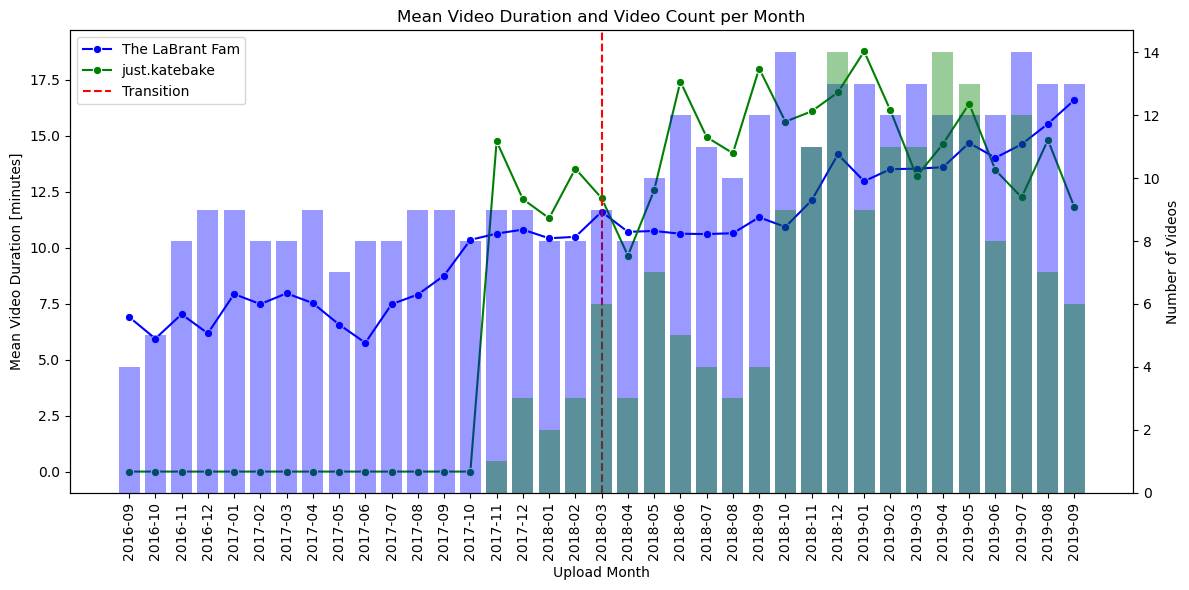

In [14]:
channel_ids = ['UC4-CH0epzZpD_ARhxCx6LaQ', 'UC0oRdyzTbGIZUISiGQnDdiw']
video_frequency_and_duration(channel_ids, df_feather, channels, start_date="2016-09", end_date="2019-09", transition_date="2018-03")

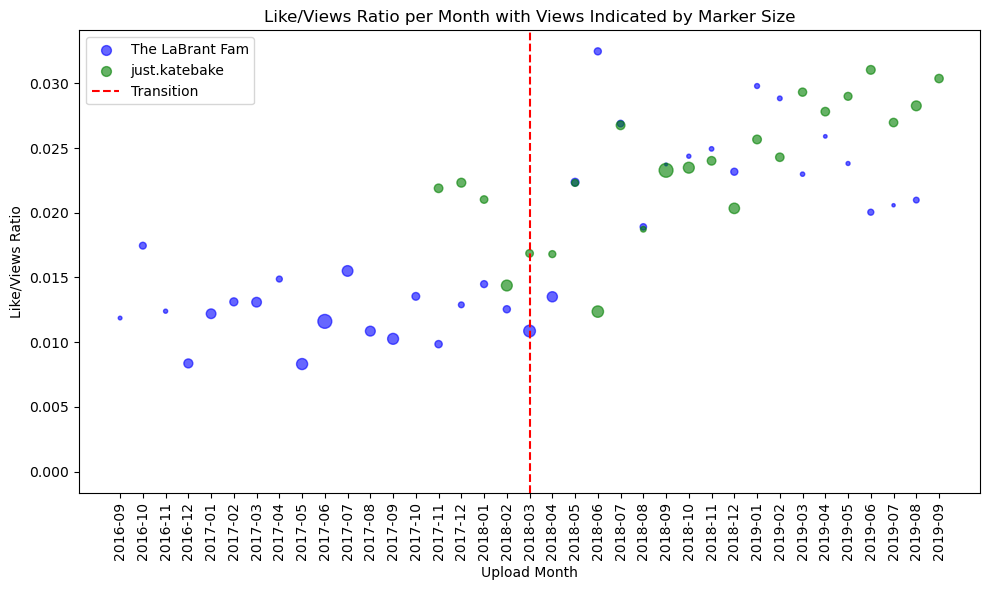

In [15]:
channel_ids = ['UC4-CH0epzZpD_ARhxCx6LaQ', 'UC0oRdyzTbGIZUISiGQnDdiw']
video_likes_and_views(channel_ids, df_feather, channels, start_date="2016-09", end_date="2019-09", transition_date="2018-03")

# 2nd milestone stuff

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import os 
# import pandas as pd
# import seaborn as sns
# import sys

In [132]:
# def category_evolution_of_channel_v0(channel_id, channels=channels_PB, df_feather=df_feather_PB):
#     '''
#     Input : a channel id, channels information dataframe and video metadata via df_feather
#     Output : annual count of number of videos of that channel in every category
#     Note : df_feather['upload_date'] should be already in datetime format
#     '''
#     # get info on the channel
#     # channel_info = channels[channels["channel"] == channel_id]
#     # display(channel_info)

#     df_feather_filt = df_feather[df_feather["channel_id"] == channel_id]
#     # For every year, count videos in each category
#     grouped_data = df_feather_filt[["year_month", "categories", "channel_id"]]
#     grouped_data = grouped_data.groupby(["year_month", "categories"]).count()
#     # Sort the values (need to transform in a regular dataframe and then put back indexes)
#     sorted_data = grouped_data.reset_index().sort_values(['year_month', 'channel_id'], ascending=[True, False])
#     sorted_data.set_index(['year_month', 'categories'], inplace=True)
#     # display(sorted_data)

#     # Select only the most popular category every year
#     most_popular_cat = sorted_data.reset_index().drop_duplicates(subset=["year_month"])
#     # display(most_popular_cat)

#     people_and_blog_proportion = len(most_popular_cat[most_popular_cat["categories"]=="People & Blogs"]) / len(most_popular_cat)
#     # print(people_and_blog_proportion)

#     return people_and_blog_proportion < 0.75

# # channel_id = 'UCcgVECVN4OKV6DH1jLkqmcA'
# # category_evolution_of_channel(channel_id)

In [ ]:
# NOTEBOOK_PATH = os.getcwd()
# DIR_PATH = os.path.dirname(NOTEBOOK_PATH)
# DATA_PATH = os.path.join(DIR_PATH, "data_youniverse")
# UTILS_PATH = os.path.join(DIR_PATH, "utils")
# CATEGORY = "Science & Technology"

# # append utils path and import utils
# sys.path.append(UTILS_PATH)
# from ploting import *
# from loading import *

In [ ]:
# df_channels_en = pd.read_csv(f"{DATA_PATH}/df_channels_en.tsv.gz", compression="infer", sep="\t") 
# # df_channels_en.head()

In [ ]:
# df_timeseries_en = pd.read_csv(f"{DATA_PATH}/df_timeseries_en.tsv.gz", compression="infer", sep="\t") # 20s
# # df_timeseries_en.head()

In [ ]:
# df_timeseries_en[df_timeseries_en['category'].isna()].channel.unique().size

In [ ]:
# df_channels_filt = df_channels_en[df_channels_en['category_cc'] == CATEGORY].copy()
# df_timeseries_filt = df_timeseries_en[df_timeseries_en['category'] == CATEGORY].copy()

In [ ]:
# helper_filt = read_and_filter_feather(f"{DATA_PATH}/yt_metadata_helper.feather", CATEGORY)
# helper_filt.head()

In [ ]:
# # UNCOMMENT IF NEEDED
# yt_metadata_filtered = load_and_filter_jsonl_gz_file_by_chunks(f"{DATA_PATH}/yt_metadata_en.jsonl.gz", CATEGORY) # 21m for pets and animals (should be the same for the other at it is reading all the file anyway)
# yt_metadata_filtered.to_csv(f"{DATA_PATH}/yt_metadata_pets&animals.csv.gz", index=False, compression="gzip") # stock the results
# yt_metadata_filtered.head()

In [ ]:
# yt_metadata_filtered.iloc[-1]['tags']

### Analysis of pets & animals category and tags

In [ ]:
# yt_metadata_filt = pd.read_csv(f"{DATA_PATH}/yt_metadata_pets&animals.csv.gz", compression="infer")
# # les channels id sont les vrai, ont peut retrouver les chaines youtube !

In [ ]:
# yt_metadata_filt['upload_date'] = pd.to_datetime(yt_metadata_filt['upload_date'])

In [ ]:
# yt_metadata_filt.describe()

### Plot the top 3 tags for a range of years

In [ ]:
# years = range(2016, 2020)  # or whatever years are applicable
# for year in years:
#     yt_metadata_filt_year = yt_metadata_filt[yt_metadata_filt['upload_date'].dt.year == year]
#     if not yt_metadata_filt_year.empty:
#         try:
#             # Assuming the function plot_topN_tag is correctly defined and can handle cases with less than N tags
#             plot_topN_tag(yt_metadata_filt_year['tags'], 3)
#         except Exception as e:
#             print(f"An error occurred for year {year}: {e}")
#     else:
#         print(f"No data available for year {year}")

### Cleaning of NaN values (not extensive)

In [ ]:
# def clean_dataframe(df):
#     # Remove rows where 'tags' is empty or NaN
#     initial_row_count = len(df)
#     df = df.dropna(subset=['tags'])  # Drops rows with NaN in 'tags'
#     df = df[df['tags'].str.strip().astype(bool)]  # Drops rows with empty 'tags'
#     cleaned_row_count = len(df)

#     # Check for NaN values in 'like_count'
#     like_count_nan = df['like_count'].isna().sum()
#     if like_count_nan > 0:
#         # Handle NaN values here. Options: fill with 0, mean, median, etc.
#         # Example: df['like_count'].fillna(df['like_count'].median(), inplace=True)
#         # For now, we'll just drop these rows
#         df = df.dropna(subset=['like_count'])

#     # Print out the cleaning summary
#     print(f"Rows with empty 'tags' removed: {initial_row_count - cleaned_row_count}")
#     print(f"Rows with NaN in 'like_count': {like_count_nan}")

#     return df

# # Clean the yt_metadata_filtered dataframe
# yt_metadata_filt_clean = clean_dataframe(yt_metadata_filt)

### Plot evolution of most popular tags

In [ ]:
# def get_top_tags_for_year(df, year, top_n=5):
#     """ Get the top N tags for a given year from the dataframe """
#     year_data = df[df['upload_date'].dt.year == year]
#     tag_list = year_data['tags'].str.split(',').explode()
#     top_tags = tag_list.value_counts().head(top_n).index
#     return top_tags

# def count_tag_appearances_by_year(df, tags):
#     """ Count the number of appearances of each tag by year """
#     df['year'] = df['upload_date'].dt.year
#     tag_counts_by_year = {tag: df[df['tags'].str.contains(tag)]['year'].value_counts().sort_index() for tag in tags}
#     return tag_counts_by_year

# def plot_tag_counts(tag_counts_by_year):
#     """ Plot the evolution of tag counts over the years """
#     plt.figure(figsize=(10, 8))
#     for tag, counts in tag_counts_by_year.items():
#         plt.plot(counts.index, counts.values, label=tag)
    
#     plt.xlabel('Year')
#     plt.ylabel('Number of Appearances')
#     plt.title('Evolution of Tag Appearances by Year')
#     plt.legend()
#     plt.show()

# top_tags_2019 = get_top_tags_for_year(yt_metadata_filt_clean, 2019)
# tag_counts_by_year = count_tag_appearances_by_year(yt_metadata_filt_clean, top_tags_2019)
# plot_tag_counts(tag_counts_by_year)

### Dataframe of statistics grouped by year

In [ ]:
# # Convert `upload_date` to DateTime and extract the year.
# yt_metadata_filt['upload_year'] = pd.to_datetime(yt_metadata_filt['upload_date']).dt.year

# # Group by the extracted year.
# grouped = yt_metadata_filt.groupby('upload_year')

# # Initialize a dictionary to hold aggregated data.
# aggregated_data = {}

# # Iterate over each group to perform aggregations.
# for name, group in grouped:
#     # Get the most popular tag for each year.
#     popular_tag = group['tags'].str.split(',').explode().value_counts().idxmax()
    
#     # Get other statistics for each year.
#     aggregated_data[name] = {
#         'most_popular_tag': popular_tag,
#         'total_like_count': group['like_count'].sum(),
#         'total_videos': group['upload_date'].count(),
#         'total_duration': group['duration'].sum(),
#         'unique_channels': group['channel_id'].nunique(),
#         'total_dislike_count': group['dislike_count'].sum(),
#         'total_view_count': group['view_count'].sum(),
#         'mean_dislike_count': group['dislike_count'].mean(),
#         'mean_like_count': group['like_count'].mean(),
#         'mean_duration': group['duration'].mean(),
#     }

# # Convert aggregated data to a DataFrame.
# stats_df = pd.DataFrame.from_dict(aggregated_data, orient='index')

# # Display the DataFrame
# stats_df.head(20)

### Plot evolution of metrics of previous dataframe

In [ ]:
# def plot_stats_over_years(df, columns):
#     """
#     Plots the evolution of specified columns from a DataFrame over the years.
    
#     Parameters:
#     - df: pandas DataFrame with a year index and columns to plot.
#     - columns: list of strings representing the column names to plot.
#     """
#     if not isinstance(columns, list):
#         columns = [columns]  # Convert to list if a single column name is passed.
        
#     for column in columns:
#         if column in df.columns:
#             plt.plot(df.index, df[column], label=column)
#         else:
#             print(f"Column '{column}' not found in the DataFrame.")
    
#     plt.xlabel('Year')
#     plt.ylabel('Value')
#     plt.title('Evolution of Statistics Over Years')
#     plt.legend()
#     plt.show()

# plot_stats_over_years(stats_df, ['total_like_count', 'total_dislike_count'])
# plot_stats_over_years(stats_df, ['mean_dislike_count', 'mean_like_count', 'mean_duration'])